# Recurrences unfolding

In [1]:
import sys

sys.setrecursionlimit(10000)

In [3]:
# %load "recurrences.py"

from functools import reduce
from string import Template

def take_apart_matched(term, indexed):
    
    wild_coeff = Wild('coeff', exclude=[indexed])
    wild_term, wild_subscript = Wild('term'), Wild('subscript')

    matched_term = term.match(wild_coeff * wild_term)

    result = None

    if matched_term: 
        coeff, indexed_term = matched_term[wild_coeff], matched_term[wild_term]
        matched_term_subscript = indexed_term.match(indexed[wild_subscript])
        if matched_term_subscript:
            term_subscript = matched_term_subscript[wild_subscript]
            result = {'coeff':coeff, 'subscript':term_subscript}

    return result


def unfold_recurrence(recurrence_spec, unfolding_recurrence_spec=None):

    if not unfolding_recurrence_spec: unfolding_recurrence_spec = recurrence_spec

    def worker(recurrence_eq, unfolding_recurrence_eq, indexed, index, terms_cache):

        def linear_matcher(subscript, variable):
            
            a_wild, b_wild = Wild('a', exclude=[variable]), Wild('b', exclude=[variable])
            matched = subscript.match(a_wild*variable + b_wild)
            
            if not matched: return None
            
            a, b = matched[a_wild], matched[b_wild]
            normalizer = lambda term: term.replace(variable, (variable - b)/a)
           
            return normalizer


        def unfolding(rhs_term):
            
            if indexed.args[0] not in rhs_term.free_symbols: return rhs_term
            elif rhs_term in terms_cache: return terms_cache[rhs_term]
            
            matched_lhs_term = take_apart_matched(recurrence_eq.lhs, indexed)
            lhs_normalizer = linear_matcher(matched_lhs_term['subscript'], index)
            norm_lhs = lhs_normalizer(recurrence_eq.lhs)

            matched_rhs_term = take_apart_matched(rhs_term, indexed)
            unfolded_term = rhs_term

            if matched_rhs_term:
                
                subs_lhs = norm_lhs.replace(index, matched_rhs_term['subscript'])
                matched_subs_lhs_term = take_apart_matched(subs_lhs, indexed)

                # since subscripts are equal by substitution, we have to check coefficients
                assert matched_subs_lhs_term['subscript'] == matched_rhs_term['subscript']

                if matched_subs_lhs_term['coeff'] == matched_rhs_term['coeff']:
                    rebuilt_rhs_term = lhs_normalizer(recurrence_eq.rhs)
                    unfolded_term = rebuilt_rhs_term.replace(index, matched_rhs_term['subscript'])
                    terms_cache[rhs_term] = unfolded_term

            if rhs_term not in terms_cache:
                    matched_norm_lhs = take_apart_matched(norm_lhs, indexed)
                    generalized_rhs_term = Mul(lhs_normalizer(recurrence_eq.rhs), 
                        Integer(1)/matched_norm_lhs['coeff'])

                    substitutions = {}
                    for subscript in indexed_terms_appearing_in(
                            rhs_term, indexed, only_subscripts=True, do_traversals=True):
                        if indexed[subscript] not in terms_cache:
                            subterm = generalized_rhs_term.replace(index, subscript)
                            substitutions.update({indexed[subscript]: subterm})

                    unfolded_term = rhs_term.subs(substitutions)
                    terms_cache.update(substitutions)
                
            return unfolded_term    
            
        unfolded_rhs_terms = map(unfolding, flatten(unfolding_recurrence_eq.rhs.args, cls=Add))
        
        folded_rhs_term = reduce(   lambda folded, addend: Add(folded, addend, evaluate=False), 
                                    unfolded_rhs_terms)
        
        return dict(recurrence_eq=Eq(recurrence_eq.lhs, folded_rhs_term),
                    indexed=indexed,
                    index=index,
                    terms_cache=terms_cache)

    return worker(  recurrence_spec['recurrence_eq'],
                    unfolding_recurrence_spec['recurrence_eq'],
                    unfolding_recurrence_spec['indexed'],
                    unfolding_recurrence_spec['index'],
                    unfolding_recurrence_spec['terms_cache'].copy())

def indexed_terms_appearing_in(term, indexed, only_subscripts=False, do_traversals=False):

    indexed_terms_set = set()

    if do_traversals: subterms_iter = preorder_traversal(term)
    else: subterms_iter = flatten(term.args, cls=Add)

    for subterm in subterms_iter:
        matched = take_apart_matched(subterm, indexed)
        if not matched: continue
        subscript = matched['subscript']
        indexed_terms_set.add(subscript if only_subscripts else indexed[subscript])

    return indexed_terms_set


def factor_rhs_unfolded_rec(unfolded_recurrence_spec):

    unfolded_recurrence_eq = unfolded_recurrence_spec['recurrence_eq']

    indexed_terms_in_rec = indexed_terms_appearing_in(
        unfolded_recurrence_eq.rhs, unfolded_recurrence_spec['indexed'])

    factored_spec = dict(**unfolded_recurrence_spec)
    factored_spec.update(recurrence_eq=Eq(unfolded_recurrence_eq.lhs, 
        Poly(unfolded_recurrence_eq.rhs, *list(indexed_terms_in_rec)).args[0]))

    return factored_spec

def apply_if(f, guard):

    def applying(*args, **kwds):
        
        result = args, kwds

        if guard: result = f(*args, **kwds) 
        elif not kwds: result = args if len(args) > 1 else args[0]
        elif not args: result = kwds

        return result

    return applying

def do_unfolding_steps(recurrence_spec, steps=1, factor_rhs=False, 
                        keep_intermediate_unfoldings=False, first_order=True):
        
    def first_order_reducer(working_recurrence_spec_folded, step): 

        unfoldings, working_recurrence_spec = working_recurrence_spec_folded

        unfolded_spec = unfold_recurrence(recurrence_spec, working_recurrence_spec)
        unfoldings.update({step:unfolded_spec})

        return unfoldings, unfolded_spec
    
    def second_order_reducer(working_recurrence_spec_folded, step): 

        unfoldings, working_recurrence_spec = working_recurrence_spec_folded

        unfolded_spec = unfold_recurrence(working_recurrence_spec, working_recurrence_spec)
        unfoldings.update({step:unfolded_spec})

        return unfoldings, unfolded_spec

    unfoldings, unfolded_recurrence_spec = reduce(
        first_order_reducer if first_order else second_order_reducer, 
        range(steps), ({}, recurrence_spec))
    
    result = None
    if keep_intermediate_unfoldings:
        result = {k:factor_rhs_unfolded_rec(v) for k,v in unfoldings.items()} \
            if factor_rhs else unfoldings
    else:
        result = factor_rhs_unfolded_rec(unfolded_recurrence_spec) \
            if factor_rhs else unfolded_recurrence_spec

    return result


def base_instantiation(unfolded_recurrence_spec, base_index=0):

    def worker(recurrence_eq, indexed, index, terms_cache):

        rhs = recurrence_eq.rhs
        rhs_summands = flatten(rhs.args, cls=Add)
        
        def subscript_equation_maker(rhs_term):
            
            matched = take_apart_matched(rhs_term, indexed)
            
            return Eq(matched['subscript'], base_index) if matched else None
        
        valid_equations = filter(lambda x: False if x is None else True, 
                                 map(subscript_equation_maker, rhs_summands))
        
        solutions = map(lambda eq: solve(eq, index)[0], valid_equations)
        
        satisfying_index = max(solutions)

        def subs_index_into(term): return term.subs(index, satisfying_index)

        new_terms_cache = {subs_index_into(k):subs_index_into(v)
                            for k,v in terms_cache.items()}

        return dict(recurrence_eq=subs_index_into(recurrence_eq),
                    indexed=indexed,
                    index=satisfying_index,
                    terms_cache=new_terms_cache)

    return worker(**unfolded_recurrence_spec)

def project_recurrence_spec(recurrence_spec, **props):
    
    projected = []
    for k,v in props.items(): 
        if v and k in recurrence_spec: projected.append(recurrence_spec[k])

    return projected[0] if len(projected) == 1 else tuple(projected)


def times_higher_order_operator(recurrence_spec, times_range=range(6), 
        operator=lambda *args: tuple(args), instantiate=True, include_last_terms_cache=False):

    initial_terms_cache = recurrence_spec['terms_cache'].copy()

    def worker(working_steps):

        unfolded_evaluated_spec = do_unfolding_steps(
            recurrence_spec, working_steps, factor_rhs=True)

        recurrence_spec['terms_cache'].update(unfolded_evaluated_spec['terms_cache'])

        processed_recurrence_spec = apply_if(
            base_instantiation, instantiate)(unfolded_evaluated_spec)

        return operator(processed_recurrence_spec, working_steps)

    mapped = map(worker, times_range)

    last_terms_cache = recurrence_spec['terms_cache'].copy()
    recurrence_spec['terms_cache'] = initial_terms_cache

    return mapped if not include_last_terms_cache else (mapped, last_terms_cache)


def repeated_instantiating(base_instantiated_rec_spec):
    
    # from sympy.core.add import _unevaluated_Add as uAdd

    indexed = base_instantiated_rec_spec['indexed']
    
    def worker(previous_terms_cache, do_one_more_step):
    
        if not do_one_more_step: return previous_terms_cache
        else: do_one_more_step = False
            
        def subterm_mapping(subterm):    
                
            nonlocal do_one_more_step
            new_subterm = subterm
            
            if subterm.free_symbols:
                new_subterm = subterm.subs(previous_terms_cache)
                if subterm != new_subterm: do_one_more_step = True
                
            return new_subterm
            
        current_terms_cache = {k:subterm_mapping(v) for k,v in previous_terms_cache.items()}
        
        return worker(current_terms_cache, do_one_more_step)

    
    fully_instantiated_terms_cache = worker(base_instantiated_rec_spec['terms_cache'], 
                                            do_one_more_step=True)
    
    fully_instantiated_rec_eq = base_instantiated_rec_spec['recurrence_eq'].subs(
        fully_instantiated_terms_cache)
    
    return dict(recurrence_eq=fully_instantiated_rec_eq, 
                indexed=indexed,
                index=base_instantiated_rec_spec['index'],
                terms_cache=fully_instantiated_terms_cache)


def latex_array_env(*args, **kwd):
    
    def eqnarray_entry_for_eq(processed_spec, working_steps):
        processed_eq = project_recurrence_spec(processed_spec, recurrence_eq=True)
        return latex(processed_eq) + r"\\"

    mapped = times_higher_order_operator(*args, **kwd, operator=eqnarray_entry_for_eq)
    template = Template(r"""\begin{array}{c}$content\end{array}""")

    return template.substitute(content="\n".join(mapped))


def ipython_latex(*args, **kwd):
    
    from IPython.display import Latex
    return Latex(latex_array_env(*args, **kwd))


---

In [4]:
import sympy
from sympy import *
from sympy.abc import x, n, z, t, k

init_printing() # for nice printing, a-la' TeX

In [101]:
a = Wild('a')
((3*n+1)*2+4*k + t).subs(2+t,z)

## Quicksort's checks recurrence

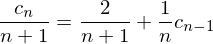

In [105]:
c = IndexedBase('c')
checks_recurrence = Eq(c[n]/(n+1), 2/(n+1) + c[n-1]/n)
checks_recurrence

In [106]:
checks_recurrence_spec=dict(recurrence_eq=checks_recurrence, indexed=c, index=n, terms_cache={})

In [107]:
unfolded = do_unfolding_steps(checks_recurrence_spec, steps=0)

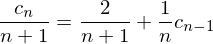

In [108]:
project_recurrence_spec(unfolded, recurrence_eq=True)

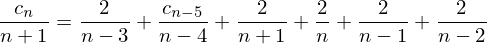

In [109]:
unfolded = do_unfolding_steps(checks_recurrence_spec,4)
recurrence_eq = project_recurrence_spec(unfolded, recurrence_eq=True)
recurrence_eq

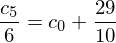

In [110]:
recurrence_eq.subs(n,5)

In [111]:
boundary_conditions = {c[0]:Integer(0)}

checks_recurrence_spec=dict(recurrence_eq=checks_recurrence, indexed=c, index=n, 
                            terms_cache=boundary_conditions)

unfolded = do_unfolding_steps(checks_recurrence_spec, steps=4)

In [112]:
instantiated_rec_spec = base_instantiation(unfolded)

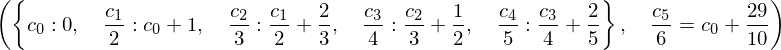

In [113]:
project_recurrence_spec(instantiated_rec_spec, recurrence_eq=True, terms_cache=True)

In [114]:
fully_instantiated_spec = repeated_instantiating(instantiated_rec_spec)

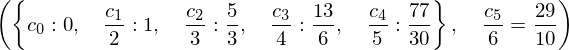

In [115]:
project_recurrence_spec(fully_instantiated_spec, recurrence_eq=True, terms_cache=True)

In [116]:
ipython_latex(checks_recurrence_spec, times_range=range(10))

<IPython.core.display.Latex object>

## Quicksort's swaps recurrence

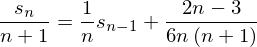

In [43]:
s = IndexedBase('s')
swaps_recurrence = Eq(s[n]/(n+1),s[n-1]/n + (2*n-3)/(6*n*(n+1)))
swaps_recurrence

In [45]:
swaps_recurrence_spec=dict(recurrence_eq=swaps_recurrence, indexed=s, index=n, terms_cache={})

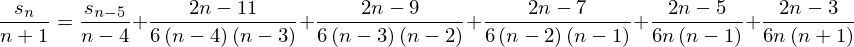

In [46]:
unfolded = do_unfolding_steps(swaps_recurrence_spec, 4)
recurrence_eq = project_recurrence_spec(unfolded, recurrence_eq=True)
recurrence_eq

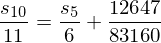

In [47]:
recurrence_eq.subs(n,10)

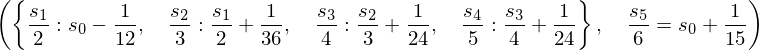

In [48]:
project_recurrence_spec(base_instantiation(unfolded), recurrence_eq=True, terms_cache=True)

### With boundary conditions

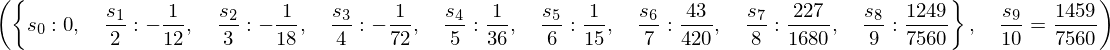

In [49]:
swaps_recurrence_spec=dict(recurrence_eq=swaps_recurrence, indexed=s, index=n, terms_cache={s[0]:Integer(0)})
unfolded = do_unfolding_steps(swaps_recurrence_spec, steps=8)
instantiated_rec_spec = base_instantiation(unfolded)
fully_instantiated_spec = repeated_instantiating(instantiated_rec_spec)
project_recurrence_spec(fully_instantiated_spec, recurrence_eq=True, terms_cache=True)

In [53]:
ipython_latex(swaps_recurrence_spec, times_range=range(10))

<IPython.core.display.Latex object>

## Fibonacci recurrence

A nice picture is [here][fibonacci-oeis].

[fibonacci-oeis]:http://oeis.org/A000045/a000045.html

### Backwards subscripts

In [11]:
f = IndexedBase('f')
fibonacci_recurrence = Eq(f[n],f[n-1]+f[n-2])
fibonacci_recurrence

In [5]:
fibonacci_recurrence_spec=dict(recurrence_eq=fibonacci_recurrence, indexed=f, index=n, terms_cache={})

In [6]:
unfolded = do_unfolding_steps(fibonacci_recurrence_spec, 5)
recurrence_eq = project_recurrence_spec(unfolded, recurrence_eq=True)
recurrence_eq

In [7]:
factored_recurrence_eq = project_recurrence_spec(factor_rhs_unfolded_rec(unfolded), recurrence_eq=True)
factored_recurrence_eq

In [8]:
factored_recurrence_eq.subs(n, 12)

In [9]:
project_recurrence_spec(base_instantiation(unfolded), recurrence_eq=True, terms_cache=True)

In [10]:
ipython_latex(fibonacci_recurrence_spec, times_range=range(10))

<IPython.core.display.Latex object>

### Forward subscripts

In [153]:
f = IndexedBase('f')
fibonacci_recurrence = Eq(f[n+2],f[n+1]+f[n])
fibonacci_recurrence

In [154]:
boundary_conditions = {f[0]:Integer(1), f[1]:Integer(1)}
fibonacci_recurrence_spec=dict(recurrence_eq=fibonacci_recurrence, indexed=f, 
                               index=n, terms_cache=boundary_conditions)

In [155]:
unfolded = do_unfolding_steps(fibonacci_recurrence_spec, 5)

In [156]:
recurrence_eq = project_recurrence_spec(unfolded, recurrence_eq=True)
recurrence_eq

In [157]:
factored_recurrence_eq = project_recurrence_spec(factor_rhs_unfolded_rec(unfolded), recurrence_eq=True)
factored_recurrence_eq

In [158]:
factored_recurrence_eq.subs(n,10)

In [159]:
instantiated_rec_spec = base_instantiation(unfolded)

In [160]:
project_recurrence_spec(instantiated_rec_spec, recurrence_eq=True, terms_cache=True)

In [161]:
fully_instantiated_spec = repeated_instantiating(instantiated_rec_spec)
project_recurrence_spec(fully_instantiated_spec, recurrence_eq=True, terms_cache=True)

In [162]:
ipython_latex(fibonacci_recurrence_spec, times_range=range(10))

<IPython.core.display.Latex object>

### Tribonacci numbers

The following is an unfolding of [Tribonacci][tribonacci] numbers recurrence.

[tribonacci]:http://oeis.org/A000073

In [32]:
f = IndexedBase('f^{(3)}')
tribonacci_recurrence = Eq(f[n+3],f[n+2]+f[n+1]+f[n])
tribonacci_recurrence

In [33]:
boundary_conditions = {f[0]:Integer(0), f[1]:Integer(0), f[2]:Integer(1)}

tribonacci_recurrence_spec=dict(recurrence_eq=tribonacci_recurrence, indexed=f, 
                               index=n, terms_cache=boundary_conditions)

In [34]:
unfolded = do_unfolding_steps(tribonacci_recurrence_spec, 5)
recurrence_eq = project_recurrence_spec(unfolded, recurrence_eq=True)
recurrence_eq

In [35]:
factored_recurrence_eq = project_recurrence_spec(factor_rhs_unfolded_rec(unfolded), recurrence_eq=True)
factored_recurrence_eq

In [36]:
instantiated_rec_spec = base_instantiation(unfolded)

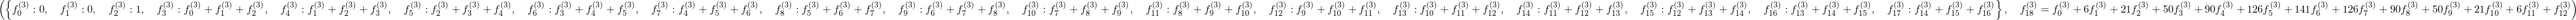

In [37]:
project_recurrence_spec(instantiated_rec_spec, recurrence_eq=True, terms_cache=True)

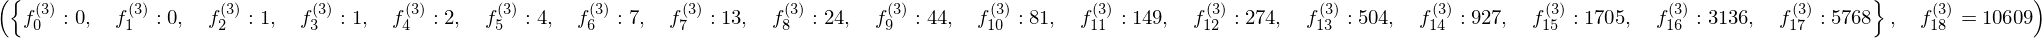

In [38]:
fully_instantiated_spec = repeated_instantiating(instantiated_rec_spec)
project_recurrence_spec(fully_instantiated_spec, recurrence_eq=True, terms_cache=True)

In [39]:
ipython_latex(tribonacci_recurrence_spec, times_range=range(7))

<IPython.core.display.Latex object>

the sequence lying on the middle in the above triangle is known as [A002426][oeis].

[oeis]:http://oeis.org/A002426

## Lucas numbers

Know as [A000032][oeis].

[oeis]:http://oeis.org/A000032

In [5]:
l = IndexedBase('l')
lucas_recurrence = Eq(l[n+2],l[n+1]+l[n])
lucas_recurrence

In [6]:
boundary_conditions = {l[0]:Integer(2), l[1]:Integer(1)}
lucas_recurrence_spec=dict(recurrence_eq=lucas_recurrence, indexed=l, 
                               index=n, terms_cache=boundary_conditions)

In [7]:
unfolded = do_unfolding_steps(lucas_recurrence_spec, 5)

In [8]:
recurrence_eq = project_recurrence_spec(unfolded, recurrence_eq=True)
recurrence_eq

In [9]:
factored_recurrence_eq = project_recurrence_spec(factor_rhs_unfolded_rec(unfolded), recurrence_eq=True)
factored_recurrence_eq

In [10]:
factored_recurrence_eq.subs(n,10)

In [11]:
instantiated_rec_spec = base_instantiation(unfolded)

In [12]:
project_recurrence_spec(instantiated_rec_spec, recurrence_eq=True, terms_cache=True)

In [13]:
fully_instantiated_spec = repeated_instantiating(instantiated_rec_spec)
project_recurrence_spec(fully_instantiated_spec, recurrence_eq=True, terms_cache=True)

In [14]:
ipython_latex(lucas_recurrence_spec, times_range=range(10))

<IPython.core.display.Latex object>

## Another recurrence relation on Fibonacci numbers

In [80]:
2+3+8+21+55+144

In [52]:
f = IndexedBase('f')
fibonacci_recurrence = Eq(f[2*n+1],f[n]**2+f[n+1]**2)
fibonacci_recurrence

In [53]:
boundary_conditions = {f[0]:Integer(1), f[1]:Integer(1)}
fibonacci_recurrence_spec=dict(recurrence_eq=fibonacci_recurrence, indexed=f, 
                               index=n, terms_cache=boundary_conditions)

In [90]:
unfolded = do_unfolding_steps(fibonacci_recurrence_spec, 2)

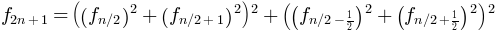

In [82]:
recurrence_eq = project_recurrence_spec(unfolded, recurrence_eq=True)
recurrence_eq

In [92]:
factored_recurrence_eq = project_recurrence_spec(factor_rhs_unfolded_rec(unfolded), recurrence_eq=True)
factored_recurrence_eq

In [95]:
factored_recurrence_eq.subs(n,3)

## Unfolding a recurrence with generic coefficients

In [41]:
s = IndexedBase('s')
a = IndexedBase('a')
swaps_recurrence = Eq(n*s[n],(n+1)*s[n-1]+a[n])
swaps_recurrence

In [42]:
boundary_conditions = {s[0]:Integer(0)}
swaps_recurrence_spec=dict(recurrence_eq=swaps_recurrence, indexed=s, 
                               index=n, terms_cache=boundary_conditions)

In [43]:
unfolded = do_unfolding_steps(swaps_recurrence_spec, 4)

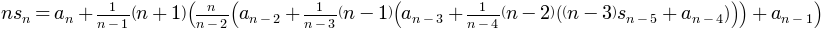

In [44]:
recurrence_eq = project_recurrence_spec(unfolded, recurrence_eq=True)
recurrence_eq

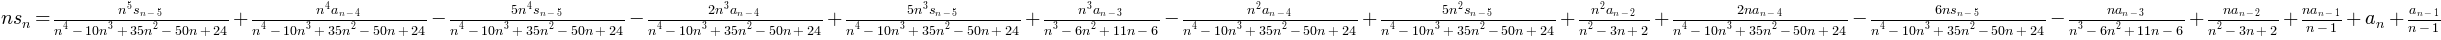

In [45]:
factored_recurrence_eq = project_recurrence_spec(factor_rhs_unfolded_rec(unfolded), recurrence_eq=True)
factored_recurrence_eq

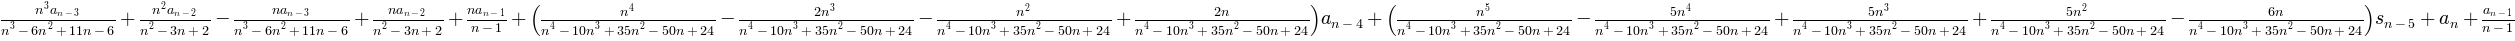

In [48]:
factored_recurrence_eq.rhs.collect(s[n-5]).collect(a[n-4])

In [49]:
factored_recurrence_eq.subs(n,5)

In [50]:
recurrence_eq.subs(n, 5)

In [51]:
def additional_term(n): return (2*Integer(n)-3)/6

as_dict = {a[n]:additional_term(n) for n in range(1,6)}

recurrence_eq.subs(n, 5).subs(as_dict)